In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, dense_diff_pool
import torch_explain as te
from torch_explain.logic.nn import entropy
from torch_explain.logic.metrics import test_explanation, complexity

import numpy as np
import pandas as pd
import utils
import model_utils
from pytorch_lightning.utilities.seed import seed_everything
import seaborn as sns
from scipy.spatial.distance import cdist
from sympy import to_dnf, lambdify
from sklearn.metrics.cluster import homogeneity_score, completeness_score

In [3]:
seed_everything(42)

Global seed set to 42


42

In [4]:
# constants
DATASET_NAME = "BA_Shapes"
NUM_CLASSES = 4
K = 10

TRAIN_TEST_SPLIT = 0.8

NUM_HIDDEN_UNITS = 20
EPOCHS = 6000
LR = 0.001

RANDOM_STATE = 0

PATH = os.path.join("..", "output", "diff_gcexplainer_lens")
utils.set_rc_params()

NUM_NODES_VIEW = 5
NUM_EXPANSIONS = 2

In [5]:
# load data
G, labels = utils.load_syn_data(DATASET_NAME)
data = utils.prepare_syn_data(G, labels, TRAIN_TEST_SPLIT)

Task: Node Classification
Number of features:  700
Number of labels:  700
Number of classes:  700
Number of edges:  2


In [6]:
# model definition

class GCN(nn.Module):
    def __init__(self, num_in_features, num_hidden_features, num_classes):
        super(GCN, self).__init__()
        
        self.name = "BA_Shapes_GCExplainer_LENs"

        self.conv0 = GCNConv(num_in_features, num_hidden_features)
        self.conv1 = GCNConv(num_hidden_features, num_hidden_features)
        self.conv2 = GCNConv(num_hidden_features, num_hidden_features)
        self.conv3 = GCNConv(num_hidden_features, num_hidden_features)
        self.conv4 = GCNConv(num_hidden_features, num_hidden_features)
        
        self.batch_norm = nn.BatchNorm1d(num_hidden_features)
        
        # linear layers
        self.linear = nn.Linear(num_hidden_features, K)
#         self.lens = torch.nn.Sequential(te.nn.EntropyLinear(K, 1, n_classes=num_classes, temperature=0.2))
        self.lens = torch.nn.Sequential(te.nn.EntropyLinear(num_hidden_features, 1, n_classes=num_classes))
        
        self.temperature = 0.2


    def forward(self, x, edge_index):
        x = self.conv0(x, edge_index)
        x = F.leaky_relu(x)

        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)

        x = self.conv2(x, edge_index)
        x = F.leaky_relu(x)
        
        x = self.conv3(x, edge_index)
        x = F.leaky_relu(x)
        
        x = self.conv4(x, edge_index)
        x = F.leaky_relu(x)
        
#         x = self.batch_norm(x)
        
        self.gnn_embedding = x
        
#         x = self.linear(x)
#         x = torch.sigmoid(x)
        x = F.softmax(x, dim=-1)
        x = torch.div(x, torch.max(x, dim=-1)[0].unsqueeze(1))
#         x = torch.exp(x/self.temperature) / (torch.sum(torch.exp(x/self.temperature), dim=1, keepdim=True) + 1e-10)
        concepts = x
        
        x = self.lens(x)
                
        return concepts, x.squeeze(-1)
    

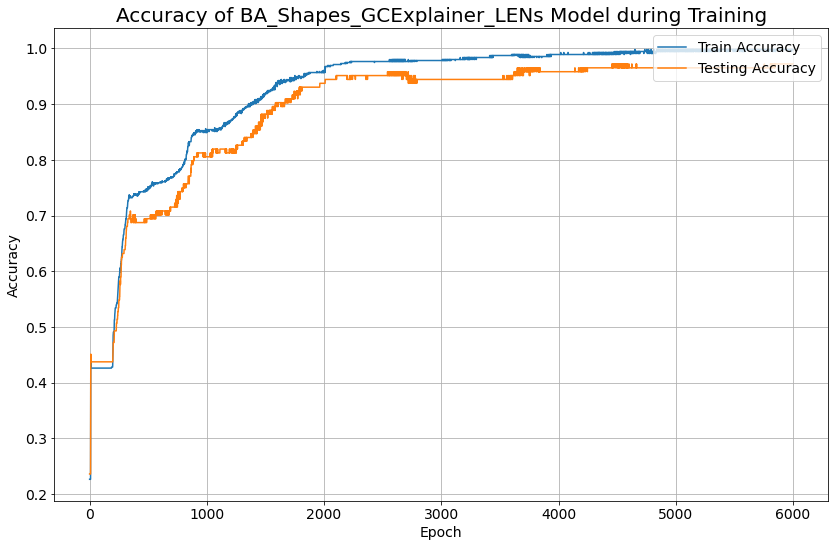

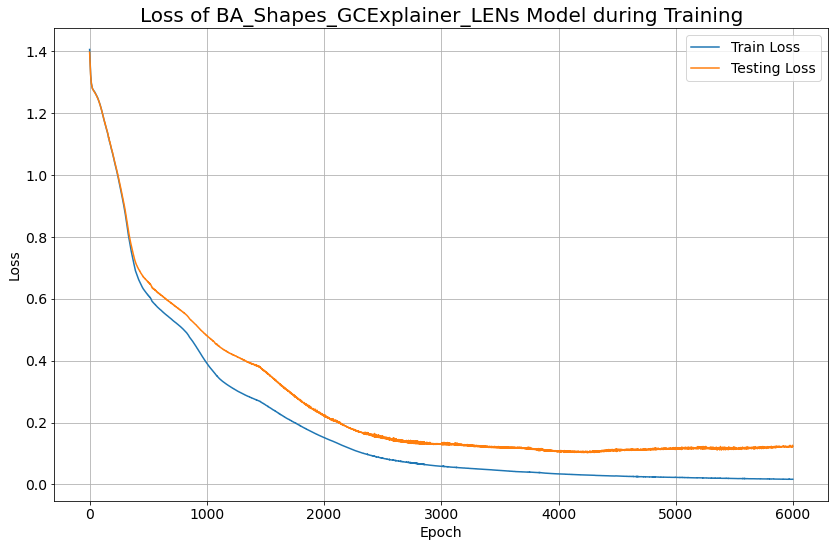

In [7]:
# model training
model = GCN(data["x"].shape[1], NUM_HIDDEN_UNITS, NUM_CLASSES)


# register hooks to track activation
model = model_utils.register_hooks(model)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# list of accuracies
train_accuracies, test_accuracies, train_losses, test_losses = list(), list(), list(), list()

# get data
x = data["x"]
edges = data["edges"].long()
y = data["y"]
train_mask = data["train_mask"]
test_mask = data["test_mask"]

def test(model, node_data_x, node_data_y, edge_list, mask):
    # enter evaluation mode
    model.eval()

    correct = 0
    _, pred = model(node_data_x, edge_list)
    pred = pred.max(dim=1)[1]

    correct += pred[mask].eq(node_data_y[mask]).sum().item()
    return correct / (len(node_data_y[mask]))


# iterate for number of epochs
for epoch in range(EPOCHS):
        # set mode to training
        model.train()
        optimizer.zero_grad()

        # input data
        concepts, out = model(x, edges)

        # calculate loss
#         quantization_loss = model_utils.quantization(model.gnn_embedding[train_mask], model.cluster_centroids)
#         loss = F.cross_entropy(out[train_mask], y[train_mask]) + 0.01 * te.nn.functional.entropy_logic_loss(model) + quantization_loss
        loss = F.cross_entropy(out[train_mask], y[train_mask]) #+ 1e-6 * quantization_loss
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            test_loss = F.cross_entropy(out[test_mask], y[test_mask])

            # get accuracy
            train_acc = test(model, x, y, edges, train_mask)
            test_acc = test(model, x, y, edges, test_mask)

        ## add to list and print
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        train_losses.append(loss.item())
        test_losses.append(test_loss.item())

        print('Epoch: {:03d}, Loss: {:.5f} Train Acc: {:.5f}, Test Acc: {:.5f}'.
              format(epoch, loss.item(), train_acc, test_acc), end = "\r")

#         if train_acc >= 0.95 and test_acc >= 0.95:
#             break

# plut accuracy graph
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Testing Accuracy")
plt.title(f"Accuracy of {model.name} Model during Training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='upper right')
plt.savefig(os.path.join(PATH, f"model_accuracy_plot.png"))
plt.show()

plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Testing Loss")
plt.title(f"Loss of {model.name} Model during Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.savefig(os.path.join(PATH, f"model_loss_plot.png"))
plt.show()

In [18]:
y1h = F.one_hot(y[train_mask])
y1h_test = F.one_hot(y[test_mask])
explanations = []
for class_id in range(y1h.shape[1]):
    explanation, _ = entropy.explain_class(model.lens, concepts[train_mask], y1h, 
                                           concepts[train_mask], y1h, target_class=class_id, 
                                           max_minterm_complexity=1000, topk_explanations=1000)
    explanations.append(explanation)
    explanation_accuracy, _ = test_explanation(explanation, concepts[test_mask], y1h_test, target_class=class_id)
    explanation_complexity = complexity(explanation)
    
    print(f'Explanation class {class_id}: {explanation} - acc. = {explanation_accuracy:.4f} - compl. = {explanation_complexity:.4f}')

AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

In [9]:
concepts, _ = model(x, edges)
concepts = concepts.detach().numpy()
edges_t = data['edge_list'].numpy()

layer_num = 4
key = 'conv4'

activation = torch.squeeze(model_utils.activation_list[key]).detach().numpy()

centroids = []
our_labels = np.zeros_like(y) - 1
centroid_labels = []
cluster_general_labels = np.unique(concepts>0.5, axis=0)
for concept in range(len(cluster_general_labels)):
    cluster_samples = np.where(((concepts>0.5)==(cluster_general_labels[concept])).all(axis=1))[0]
    centroid = np.mean(activation[cluster_samples], axis=0)
#     centroid = np.average(activation[cluster_samples], axis=0, weights=activation[cluster_samples])
    
    our_labels[cluster_samples] = concept
    centroid_labels.append(concept)
    centroids.append(centroid)
    
centroids = np.vstack(centroids)
centroid_labels = np.stack(centroid_labels)

In [10]:
len(centroids)

29

C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\seaborn\utils.py:95: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.canvas.draw()


<Figure size 720x720 with 0 Axes>

C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


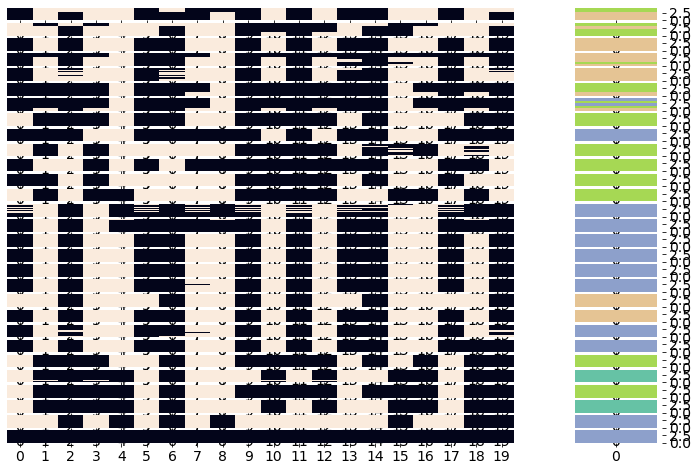

In [11]:
plt.figure(figsize=[10, 10])
fig, ax = plt.subplots(len(centroids), 2, gridspec_kw={'width_ratios': [5, 1]})
for i in range(len(centroids)):
    sns.heatmap(activation[our_labels==i]>0.5, cbar=None, ax=ax[i, 0])
    sns.heatmap(y[our_labels==i].unsqueeze(-1), vmin=0, vmax=4, cmap="Set2", ax=ax[i, 1])

In [21]:
# concept alignment
homogeneity_score(y, our_labels)

0.9769573841830015

In [23]:
# clustering efficency
completeness_score(y, our_labels)

0.6681570950288821

In [12]:
explanations

['feature0000000011 & ~feature0000000010',
 'feature0000000010 | (~feature0000000002 & ~feature0000000007) | (~feature0000000002 & ~feature0000000008 & ~feature0000000014)',
 '~feature0000000004 & ~feature0000000007 & ~feature0000000016',
 '~feature0000000000 & ~feature0000000016 & ~feature0000000019']

C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an expli

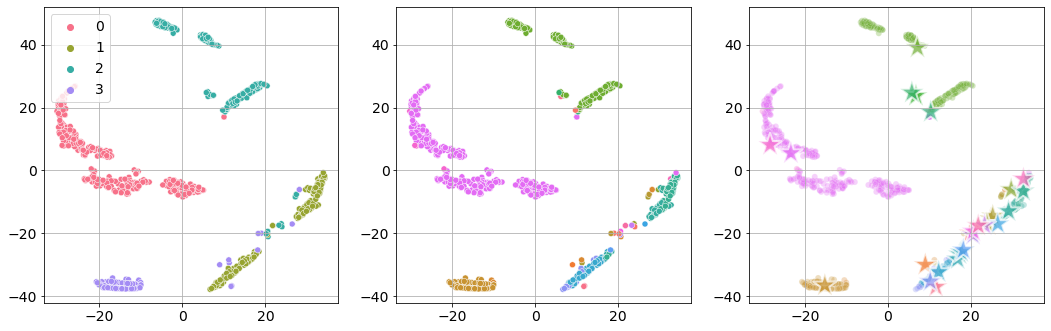

In [13]:
all_data = np.vstack([activation, centroids])
tsne_model = TSNE(n_components=2)
all_data2d = tsne_model.fit_transform(all_data)
d = all_data2d[:len(activation)]
centroids2d = all_data2d[len(activation):]

plt.figure(figsize=[15, 5])
plt.subplot(1, 3, 1)
p = sns.color_palette("husl", len(np.unique(y)))
sns.scatterplot(d[:, 0], d[:, 1], hue=y, palette=p)
plt.subplot(1, 3, 2)
p = sns.color_palette("husl", len(centroids))
sns.scatterplot(d[:, 0], d[:, 1], hue=our_labels, palette=p, legend=None)
# sns.scatterplot(centroids2d[:, 0], centroids2d[:, 1], hue=centroid_labels, palette=p, legend=None, **{'s': 600, 'marker': '*'})
plt.subplot(1, 3, 3)
p = sns.color_palette("husl", len(centroids))
sns.scatterplot(d[:, 0], d[:, 1], hue=our_labels, palette=p, legend=None, alpha=0.3)
sns.scatterplot(centroids2d[:, 0], centroids2d[:, 1], hue=centroid_labels, palette=p, alpha=0.7,
                legend=None, **{'s': 600, 'marker': '*', 'edgecolors': None})
plt.savefig(os.path.join(PATH, f"DifferentialClustering_{layer_num}layer_Raw.png"))
plt.show()

In [17]:
np.unique(our_labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28], dtype=int64),
 array([  3,   4,   1,   6,  67,   3,   5,   1,   1, 145,   1,   1,   1,
         54,  26,   2,   4,   2,  47,   1,   1,  17,   1,   1, 297,   1,
          4,   1,   2], dtype=int64))

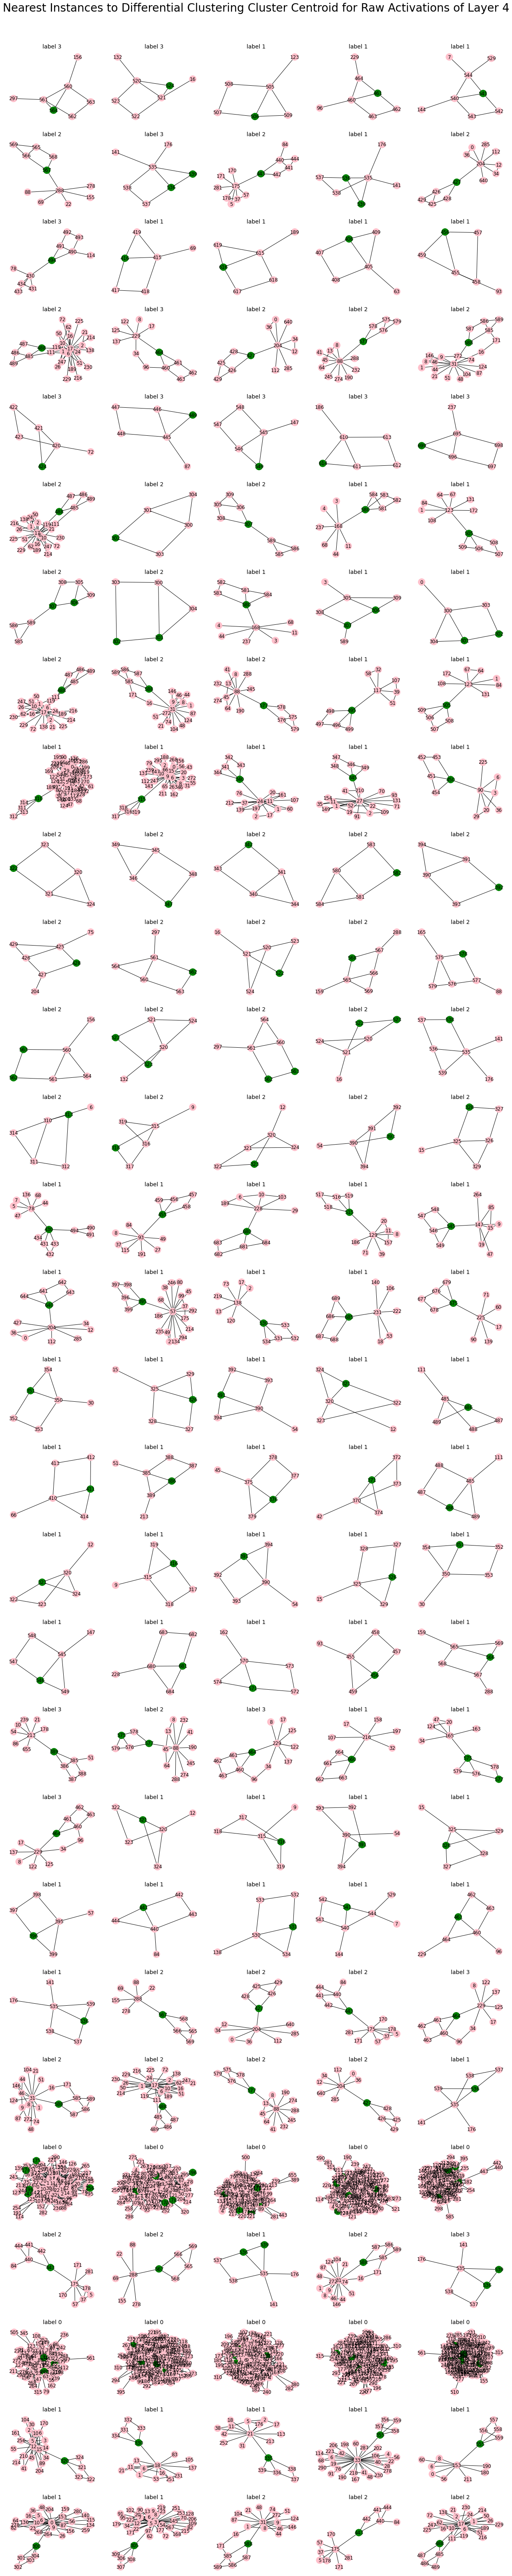

In [14]:
sample_graphs, sample_feat = utils.plot_samples(None, activation, y, layer_num, len(centroids), "Differential Clustering", "Raw", NUM_NODES_VIEW, edges_t, NUM_EXPANSIONS, PATH, concepts=centroids)